# Goal 3 - Predicting Attention

## Data Modeling

### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model, datasets
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score


from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
)

import shap
import warnings
warnings.filterwarnings('ignore')

### Import the pre processed dataset

In [2]:
df_final = pd.read_csv("project_df_final.csv", delimiter=",")

### In looking_at_screen switch 0 and 1 so that "1" corresponds to "looking_at_screen"

In [3]:
df_final["looking_at_screen"] = df_final["looking_at_screen"].replace({0: 1, 1: 0})

### Filter data where person is looking at screen

In [4]:
df_looking = df_final[df_final["looking_at_screen"] == 1]

In [5]:
df_looking["looking_at_screen"].unique()

array([1])

In [6]:
persons_looking = df_looking["person_id"].unique()

### Generate dataframe of people who at least looked once at the screen

In [7]:
df_pl = df_final[
    df_final["person_id"].isin(persons_looking)
]  

### Check ratio of people having looked once at the screen vs total data

In [8]:
df_pl.shape[0] / df_final.shape[0] * 100  

42.734230266515866

### Generate shifted columns to make the label

In [9]:
df_pl["shift_looking_1"] = df_pl["looking_at_screen"].shift(-1, fill_value=0)
df_pl["shift_looking_2"] = df_pl["looking_at_screen"].shift(-2, fill_value=0)
df_pl["shift_looking_3"] = df_pl["looking_at_screen"].shift(-3, fill_value=0)
df_pl["shift_looking_4"] = df_pl["looking_at_screen"].shift(-4, fill_value=0)
df_pl["shift_looking_5"] = df_pl["looking_at_screen"].shift(-5, fill_value=0)

df_pl["shift_person_id_1"] = df_pl["person_id"].shift(-1, fill_value=0)
df_pl["shift_person_id_2"] = df_pl["person_id"].shift(-2, fill_value=0)
df_pl["shift_person_id_5"] = df_pl["person_id"].shift(-5, fill_value=0)

In [10]:
#df_pl.head(2)

### Label for looking in the next second 

In [11]:
df_pl["pl_sum1"] = df_pl["shift_looking_1"]

### Label for looking in the next 2 seconds

In [12]:
df_pl["pl_sum2"] = df_pl["shift_looking_1"] + df_pl["shift_looking_2"]

### Label for looking in the next 5 seconds

In [13]:
df_pl["pl_sum5"] = (
    df_pl["shift_looking_1"]
    + df_pl["shift_looking_2"]
    + df_pl["shift_looking_3"]
    + df_pl["shift_looking_4"]
    + df_pl["shift_looking_5"]
)

In [14]:
df_pl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888322 entries, 37 to 2078712
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   local_timestamp           888322 non-null  object 
 1   headpose_pitch            841056 non-null  float64
 2   headpose_roll             841056 non-null  float64
 3   headpose_yaw              841056 non-null  float64
 4   looking_at_screen         888322 non-null  int64  
 5   person_id                 888322 non-null  object 
 6   poi_id                    888322 non-null  int64  
 7   x_world                   888322 non-null  float64
 8   y_world                   888322 non-null  float64
 9   z_world                   888322 non-null  float64
 10  present_in_1              888322 non-null  int64  
 11  present_in_2              888322 non-null  int64  
 12  present_in_5              888322 non-null  int64  
 13  gender                    888322 non-null 

### Reset the index

In [15]:
df_pl = df_pl.reset_index(drop=True)

In [16]:
df_pl["shift_looking_5"].value_counts()

0    783669
1    104653
Name: shift_looking_5, dtype: int64

In [17]:
df_pl["looking_at_screen"].value_counts()

0    783668
1    104654
Name: looking_at_screen, dtype: int64

### When present at any point in the next n seconds, the value for the label should be max 1

In [18]:
def makeOne(value):
    if value > 1:
        value = 1
    return value

In [19]:
makeOne(df_pl["pl_sum2"][0])

1

#### df_pl["pl_sum2"] and df_pl["pl_sum5"] have values higher than 1 and we make is all 1

In [20]:
df_pl["pl_sum2"] = df_pl["pl_sum2"].apply(lambda x: makeOne(x))
df_pl["pl_sum5"] = df_pl["pl_sum5"].apply(lambda x: makeOne(x))

### make the sum (=label) 0 if the value is leaking from the next person_id because of shifted columns

In [21]:
mask_1 = df_pl["person_id"] != df_pl["shift_person_id_1"]
df_pl["pl_sum1"][mask_1] = 0

In [22]:
mask_2 = df_pl["person_id"] != df_pl["shift_person_id_2"]
df_pl["pl_sum2"][mask_2] = 0

In [23]:
mask_5 = df_pl["person_id"] != df_pl["shift_person_id_5"]
df_pl["pl_sum5"][mask_5] = 0

In [24]:
df_pl["pl_sum1"].value_counts()

0    788465
1     99857
Name: pl_sum1, dtype: int64

### Rebalance dataset, fist get indices to drop where label of looking_at_screen in x seconds = 0 

In [25]:
index_to_drop = df_pl[df_pl["pl_sum5"] == 0].sample(frac=0.5).index

In [26]:
df_balanced_goal3 = df_pl.drop(index_to_drop)

### Check label balance after balancing dataset

In [27]:
df_balanced_goal3["pl_sum1"].value_counts()

0    444623
1     91250
Name: pl_sum1, dtype: int64

In [28]:
df_balanced_goal3["pl_sum2"].value_counts()

0    414516
1    121357
Name: pl_sum2, dtype: int64

In [29]:
df_balanced_goal3["pl_sum5"].value_counts()

0    352449
1    183424
Name: pl_sum5, dtype: int64

In [30]:
df_balanced_goal3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535873 entries, 0 to 888320
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   local_timestamp           535873 non-null  object 
 1   headpose_pitch            504554 non-null  float64
 2   headpose_roll             504554 non-null  float64
 3   headpose_yaw              504554 non-null  float64
 4   looking_at_screen         535873 non-null  int64  
 5   person_id                 535873 non-null  object 
 6   poi_id                    535873 non-null  int64  
 7   x_world                   535873 non-null  float64
 8   y_world                   535873 non-null  float64
 9   z_world                   535873 non-null  float64
 10  present_in_1              535873 non-null  int64  
 11  present_in_2              535873 non-null  int64  
 12  present_in_5              535873 non-null  int64  
 13  gender                    535873 non-null  o

### Shifted columns are not needed any more, drop them

In [31]:
df_balanced_goal3 = df_balanced_goal3.drop(["shift_looking_1", "shift_looking_2", "shift_looking_3", "shift_looking_4", "shift_looking_5",
                                            "shift_person_id_1", "shift_person_id_2", "shift_person_id_5"], axis = 1)

In [32]:
df_balanced_goal3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535873 entries, 0 to 888320
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   local_timestamp           535873 non-null  object 
 1   headpose_pitch            504554 non-null  float64
 2   headpose_roll             504554 non-null  float64
 3   headpose_yaw              504554 non-null  float64
 4   looking_at_screen         535873 non-null  int64  
 5   person_id                 535873 non-null  object 
 6   poi_id                    535873 non-null  int64  
 7   x_world                   535873 non-null  float64
 8   y_world                   535873 non-null  float64
 9   z_world                   535873 non-null  float64
 10  present_in_1              535873 non-null  int64  
 11  present_in_2              535873 non-null  int64  
 12  present_in_5              535873 non-null  int64  
 13  gender                    535873 non-null  o

In [33]:
df_balanced_goal3["headpose_pitch"].isnull().value_counts()

False    504554
True      31319
Name: headpose_pitch, dtype: int64

### headpose labels are used as features for modeling, replace NaNs with 0

In [34]:
df_balanced_goal3["headpose_pitch"] = df_balanced_goal3["headpose_pitch"].fillna(0)

In [35]:
df_balanced_goal3["headpose_roll"] = df_balanced_goal3["headpose_roll"].fillna(0)

In [36]:
df_balanced_goal3["headpose_yaw"] = df_balanced_goal3["headpose_yaw"].fillna(0)

In [37]:
df_balanced_goal3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535873 entries, 0 to 888320
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   local_timestamp           535873 non-null  object 
 1   headpose_pitch            535873 non-null  float64
 2   headpose_roll             535873 non-null  float64
 3   headpose_yaw              535873 non-null  float64
 4   looking_at_screen         535873 non-null  int64  
 5   person_id                 535873 non-null  object 
 6   poi_id                    535873 non-null  int64  
 7   x_world                   535873 non-null  float64
 8   y_world                   535873 non-null  float64
 9   z_world                   535873 non-null  float64
 10  present_in_1              535873 non-null  int64  
 11  present_in_2              535873 non-null  int64  
 12  present_in_5              535873 non-null  int64  
 13  gender                    535873 non-null  o

### Create sub dataframes for each installation 
### Define function to split sub dataframes into X_train, y_train, X_test, y_test


In [38]:
def define_target_per_poi(
    sec, df=df_balanced_goal3, columns=[],
):
    if columns == []:
        columns = [
            "poi_id",
            "person_id",
            "x_world",
            "y_world",
            "age",
            "gender",
            "looking_at_screen",
            "headpose_pitch",
            "headpose_roll",
            "headpose_yaw",
            "ema_5_x",
            "ema_5_y",
            "ema_5_velocity",
            "ema_10_x",
            "ema_10_y",
            "ema_10_velocity",
            "cumulative_time",
        ]
        
    
    

    columns.append("pl_sum" + str(sec))
    df_model = df[columns]
    print("The model target window is " + str(sec) + " seconds. \n")
    print(df_model.info())

    df_inst_1 = df_model.loc[df["poi_id"] == 444]
    df_inst_450 = df_model.loc[df["poi_id"] == 450]
    df_inst_453 = df_model.loc[df["poi_id"] == 453]
    df_inst_456 = df_model.loc[df["poi_id"] == 456]
    df_inst_457 = df_model.loc[df["poi_id"] == 457]
    df_inst_466 = df_model.loc[df["poi_id"] == 466]
    df_inst_529 = df_model.loc[df["poi_id"] == 529]

    return (
        df_inst_1,
        df_inst_450,
        df_inst_453,
        df_inst_456,
        df_inst_457,
        df_inst_466,
        df_inst_529,
    )


def split_per_group(d):

    train_inds, test_inds = next(
        GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=42).split(
            d, groups=d["person_id"]
        )
    )

    train = d.iloc[train_inds]
    test = d.iloc[test_inds]

    y_train = train.iloc[:, -1]
    y_test = test.iloc[:, -1]

    # Drop present_in_sec, person_id and POI_id from our POI dataframes (not needed and leading to errors)
    X_train = train[train.columns[2:-1]]
    X_test = test[test.columns[2:-1]]

    return X_train, y_train, X_test, y_test

(
    df_inst_444_1,
    df_inst_450_1,
    df_inst_453_1,
    df_inst_456_1,
    df_inst_457_1,
    df_inst_466_1,
    df_inst_529_1,
) = define_target_per_poi(1,)


X_train_444_1, y_train_444_1, X_test_444_1, y_test_444_1 = split_per_group(df_inst_444_1)
X_train_450_1, y_train_450_1, X_test_450_1, y_test_450_1 = split_per_group(df_inst_450_1)
X_train_453_1, y_train_453_1, X_test_453_1, y_test_453_1 = split_per_group(df_inst_453_1)
X_train_456_1, y_train_456_1, X_test_456_1, y_test_456_1 = split_per_group(df_inst_456_1)
X_train_457_1, y_train_457_1, X_test_457_1, y_test_457_1 = split_per_group(df_inst_457_1)
X_train_466_1, y_train_466_1, X_test_466_1, y_test_466_1 = split_per_group(df_inst_466_1)
X_train_529_1, y_train_529_1, X_test_529_1, y_test_529_1 = split_per_group(df_inst_529_1)

(
    df_inst_444_2,
    df_inst_450_2,
    df_inst_453_2,
    df_inst_456_2,
    df_inst_457_2,
    df_inst_466_2,
    df_inst_529_2,
) = define_target_per_poi(2,)

X_train_444_2, y_train_444_2, X_test_444_2, y_test_444_2 = split_per_group(df_inst_444_2)
X_train_450_2, y_train_450_2, X_test_450_2, y_test_450_2 = split_per_group(df_inst_450_2)
X_train_453_2, y_train_453_2, X_test_453_2, y_test_453_2 = split_per_group(df_inst_453_2)
X_train_456_2, y_train_456_2, X_test_456_2, y_test_456_2 = split_per_group(df_inst_456_2)
X_train_457_2, y_train_457_2, X_test_457_2, y_test_457_2 = split_per_group(df_inst_457_2)
X_train_466_2, y_train_466_2, X_test_466_2, y_test_466_2 = split_per_group(df_inst_466_2)
X_train_529_2, y_train_529_2, X_test_529_2, y_test_529_2 = split_per_group(df_inst_529_2)


(
    df_inst_444_5,
    df_inst_450_5,
    df_inst_453_5,
    df_inst_456_5,
    df_inst_457_5,
    df_inst_466_5,
    df_inst_529_5,
) = define_target_per_poi(5,)

X_train_444_5, y_train_444_5, X_test_444_5, y_test_444_5 = split_per_group(df_inst_444_5)
X_train_450_5, y_train_450_5, X_test_450_5, y_test_450_5 = split_per_group(df_inst_450_5)
X_train_453_5, y_train_453_5, X_test_453_5, y_test_453_5 = split_per_group(df_inst_453_5)
X_train_456_5, y_train_456_5, X_test_456_5, y_test_456_5 = split_per_group(df_inst_456_5)
X_train_457_5, y_train_457_5, X_test_457_5, y_test_457_5 = split_per_group(df_inst_457_5)
X_train_466_5, y_train_466_5, X_test_466_5, y_test_466_5 = split_per_group(df_inst_466_5)
X_train_529_5, y_train_529_5, X_test_529_5, y_test_529_5 = split_per_group(df_inst_529_5)

train_test_per_camera = [[X_train_444_1, y_train_444_1, X_test_444_1, y_test_444_1],
                         [X_train_450_1, y_train_450_1, X_test_450_1, y_test_450_1],
                         [X_train_453_1, y_train_453_1, X_test_453_1, y_test_453_1],
                         [X_train_456_1, y_train_456_1, X_test_456_1, y_test_456_1],
                         [X_train_457_1, y_train_457_1, X_test_457_1, y_test_457_1],
                         [X_train_466_1, y_train_466_1, X_test_466_1, y_test_466_1],
                         [X_train_529_1, y_train_529_1, X_test_529_1, y_test_529_1], 
                         
                         [X_train_444_2, y_train_444_2, X_test_444_2, y_test_444_2],
                         [X_train_450_2, y_train_450_2, X_test_450_2, y_test_450_2],
                         [X_train_453_2, y_train_453_2, X_test_453_2, y_test_453_2],
                         [X_train_456_2, y_train_456_2, X_test_456_2, y_test_456_2],
                         [X_train_457_2, y_train_457_2, X_test_457_2, y_test_457_2],
                         [X_train_466_2, y_train_466_2, X_test_466_2, y_test_466_2],
                         [X_train_529_2, y_train_529_2, X_test_529_2, y_test_529_2],
                           
                         [X_train_444_5, y_train_444_5, X_test_444_5, y_test_444_5],
                         [X_train_450_5, y_train_450_5, X_test_450_5, y_test_450_5],
                         [X_train_453_5, y_train_453_5, X_test_453_5, y_test_453_5],
                         [X_train_456_5, y_train_456_5, X_test_456_5, y_test_456_5],
                         [X_train_457_5, y_train_457_5, X_test_457_5, y_test_457_5],
                         [X_train_466_5, y_train_466_5, X_test_466_5, y_test_466_5],
                         [X_train_529_5, y_train_529_5, X_test_529_5, y_test_529_5], 
                        
                        ]


train_test_per_camera_dict = {        
                             
                         'cam444_1':[X_train_444_1, y_train_444_1, X_test_444_1, y_test_444_1],
                         'cam450_1':[X_train_450_1, y_train_450_1, X_test_450_1, y_test_450_1],
                         'cam453_1':[X_train_453_1, y_train_453_1, X_test_453_1, y_test_453_1],
                         'cam456_1':[X_train_456_1, y_train_456_1, X_test_456_1, y_test_456_1],
                         'cam457_1':[X_train_457_1, y_train_457_1, X_test_457_1, y_test_457_1],
                         'cam466_1':[X_train_466_1, y_train_466_1, X_test_466_1, y_test_466_1],
                         'cam529_1':[X_train_529_1, y_train_529_1, X_test_529_1, y_test_529_1], 
                         
                         'cam444_2':[X_train_444_2, y_train_444_2, X_test_444_2, y_test_444_2],
                         'cam450_2':[X_train_450_2, y_train_450_2, X_test_450_2, y_test_450_2],
                         'cam453_2':[X_train_453_2, y_train_453_2, X_test_453_2, y_test_453_2],
                         'cam456_2':[X_train_456_2, y_train_456_2, X_test_456_2, y_test_456_2],
                         'cam457_2':[X_train_457_2, y_train_457_2, X_test_457_2, y_test_457_2],
                         'cam466_2':[X_train_466_2, y_train_466_2, X_test_466_2, y_test_466_2],
                         'cam529_2':[X_train_529_2, y_train_529_2, X_test_529_2, y_test_529_2],
                           
                         'cam444_5':[X_train_444_5, y_train_444_5, X_test_444_5, y_test_444_5],
                         'cam450_5':[X_train_450_5, y_train_450_5, X_test_450_5, y_test_450_5],
                         'cam453_5':[X_train_453_5, y_train_453_5, X_test_453_5, y_test_453_5],
                         'cam456_5':[X_train_456_5, y_train_456_5, X_test_456_5, y_test_456_5],
                         'cam457_5':[X_train_457_5, y_train_457_5, X_test_457_5, y_test_457_5],
                         'cam466_5':[X_train_466_5, y_train_466_5, X_test_466_5, y_test_466_5],
                         'cam529_5':[X_train_529_5, y_train_529_5, X_test_529_5, y_test_529_5], 
                            }

The model target window is 1 seconds. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535873 entries, 0 to 888320
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   poi_id             535873 non-null  int64  
 1   person_id          535873 non-null  object 
 2   x_world            535873 non-null  float64
 3   y_world            535873 non-null  float64
 4   age                535873 non-null  float64
 5   gender             535873 non-null  object 
 6   looking_at_screen  535873 non-null  int64  
 7   headpose_pitch     535873 non-null  float64
 8   headpose_roll      535873 non-null  float64
 9   headpose_yaw       535873 non-null  float64
 10  ema_5_x            535873 non-null  float64
 11  ema_5_y            535873 non-null  float64
 12  ema_5_velocity     535873 non-null  float64
 13  ema_10_x           535873 non-null  float64
 14  ema_10_y           535873 non-null  float64
 15  ema_10_velo

In [39]:
# df_balanced_goal3.info()

In [40]:
# df_balanced_goal3.head(3)

### Modeling Pipeline (transformers, preprocessor, model)

In [41]:
# Define numerical features
numerical_features = [
    "x_world",
    "y_world",
    "age",
    "ema_5_x",
    "ema_5_y",
    "ema_5_velocity",
    "ema_10_x",
    "ema_10_y",
    "ema_10_velocity",
     "headpose_pitch",
    "headpose_roll",
    "headpose_yaw",
    "cumulative_time",
]


# Define categorical features
categorical_features = ["gender", "looking_at_screen"]

# Define transformers
numerical_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler()),]
) 

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# Combine feature transformers
data_transformer = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
) 

# Define preprocessing pipeline (data transformation & dimension reduction, not included for now)
preprocessor = Pipeline(steps=[("data_transformer", data_transformer),])

# Define model pipeline
rf_model = RandomForestClassifier()
rfc_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_model)])

### Define function for runing and evaluating model

In [78]:

def run_models(model_name, pipe, X_train, y_train, X_test, y_test):
        
    fit = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    probability = pipe.predict_proba(X_test)
    score = pipe.score(X_test, y_test)

    print(classification_report(y_test, predictions))
    
    
    feats = {}  # a dict to hold feature_name: feature_importance
    for feature, importance in zip(X_test.columns, rfc_pipe.named_steps["classifier"].feature_importances_):
        feats[feature] = importance  # add the name/value pair

    importances = pd.DataFrame.from_dict(feats, orient="index").rename(columns={0: "Gini-importance"})
    print(importances.sort_values(by="Gini-importance", ascending=False))
    
    return probability

### Run Model

In [79]:
dict1 = {'cam444_1':[X_train_444_1, y_train_444_1, X_test_444_1, y_test_444_1], 
         #'cam444_2':[X_train_444_2, y_train_444_2, X_test_444_2, y_test_444_2]
        }

# for key, value in train_test_per_camera_dict.items():
for key, value in dict1.items():
    print ("\n-----",key)
    prob = run_models("rfc", rfc_pipe,*value)


----- cam444_1
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      6190
           1       0.82      0.69      0.75      1979

    accuracy                           0.89      8169
   macro avg       0.86      0.82      0.84      8169
weighted avg       0.88      0.89      0.88      8169

                   Gini-importance
probs                     0.200442
label                     0.174966
ema_10_x                  0.079778
y_world                   0.060576
ema_5_y                   0.050411
headpose_yaw              0.049730
looking_at_screen         0.049527
x_world                   0.047893
ema_5_x                   0.043694
headpose_pitch            0.042993
gender                    0.042525
headpose_roll             0.042365
ema_10_y                  0.038202
age                       0.034104
ema_5_velocity            0.033431
ema_10_velocity           0.004713
cumulative_time           0.004649


## Comparing probabilities with actual label for one installation

In [44]:
X_test_444_1['probs'] = prob[:,1]
X_test_444_1['label'] = y_test_444_1
X_test_444_1

,x_world,y_world,age,gender,looking_at_screen,headpose_pitch,headpose_roll,headpose_yaw,ema_5_x,ema_5_y,ema_5_velocity,ema_10_x,ema_10_y,ema_10_velocity,cumulative_time,probs,label
309,-1.654320,4.840046,44.0,male,0,20.0,12.0,49.0,0.001530,-0.038520,0.066790,0.001859,-0.030171,0.066634,3,0.06,0
311,-1.659930,4.844810,44.0,male,0,24.0,15.0,50.0,-0.007881,0.048203,0.090527,-0.004754,0.030365,0.082303,5,0.07,0
312,-1.631776,4.694041,44.0,male,0,9.0,2.0,31.0,0.000962,0.053995,0.082122,0.000511,0.038605,0.078565,6,0.13,0
313,-1.648870,4.629479,44.0,male,0,9.0,2.0,31.0,-0.001319,0.028253,0.060915,-0.000883,0.025222,0.065465,7,0.14,0
315,-1.637585,4.669059,44.0,male,0,348.0,2.0,17.0,-0.023455,-0.019790,0.066157,-0.014895,-0.004886,0.065677,9,0.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69107,-0.676429,2.096480,43.0,female,0,4.0,5.0,43.0,-0.306603,0.641657,0.772481,-0.195466,0.482205,0.610184,34,0.03,0
69109,0.757040,1.462493,43.0,female,0,3.0,3.0,20.0,-0.600017,0.317086,0.809687,-0.406067,0.343918,0.685357,36,0.05,0
69110,1.612524,1.458722,43.0,female,0,3.0,3.0,20.0,-0.753391,0.298147,0.903665,-0.525048,0.328701,0.759259,37,0.04,0
69111,2.672665,1.198453,43.0,female,0,3.0,3.0,20.0,-0.828990,0.278510,0.938763,-0.607833,0.312429,0.804677,38,0.05,0


## Model Results Visualization

Text(0.5, 1.0, 'label: looking at screen')

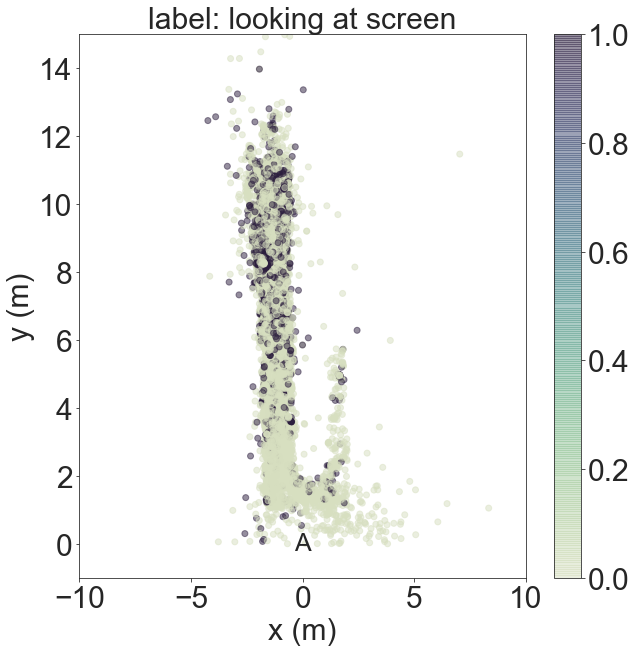

In [80]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 10))

z = X_test_444_1["label"]
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

points = ax.scatter(X_test_444_1["x_world"], X_test_444_1["y_world"], c=z, cmap=cmap, alpha = 0.5)

ax.text(
        0,
        0,
        "A",
        fontsize=25,
        horizontalalignment="center",
        verticalalignment="center",
        bbox=dict(facecolor="none", edgecolor="none", alpha=1),
    )

fig.colorbar(points)
plt.xlim(-10,10)
plt.ylim(-1,15)
ax.tick_params(axis="both", which="major", labelsize=30)
plt.xlabel("x (m)", fontsize=30)
plt.ylabel("y (m)", fontsize=30)
ax.figure.axes[-1].tick_params(labelsize=30)
ax.set_title("label: looking at screen", fontsize=30)

Text(0.5, 1.0, 'prediction: looking at screen')

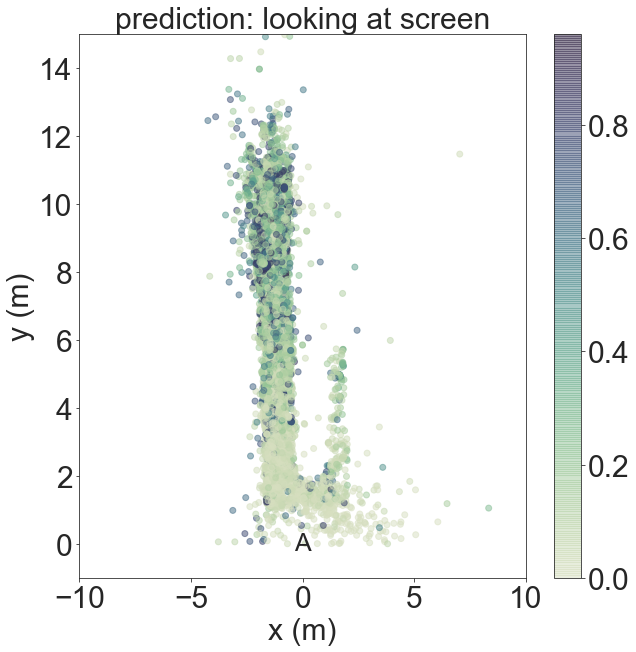

In [81]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 10))

z = X_test_444_1["probs"]
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

ax.text(
        0,
        0,
        "A",
        fontsize=25,
        horizontalalignment="center",
        verticalalignment="center",
        bbox=dict(facecolor="none", edgecolor="none", alpha=1),
    )

points = ax.scatter(X_test_444_1["x_world"], X_test_444_1["y_world"], c=z, cmap=cmap, alpha = 0.5)
fig.colorbar(points)
plt.xlim(-10,10)
plt.ylim(-1,15)
ax.tick_params(axis="both", which="major", labelsize=30)
plt.xlabel("x (m)", fontsize=30)
plt.ylabel("y (m)", fontsize=30)
ax.figure.axes[-1].tick_params(labelsize=30)
ax.set_title("prediction: looking at screen", fontsize=30)